# MarlimR3D - Meshes and Models

In [1]:
import emg3d
import discretize
import numpy as np
import xarray as xr
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.colors import LogNorm

In [2]:
%matplotlib notebook

## Load survey info

In [3]:
data = xr.load_dataset('marlim_survey.nc', engine='h5netcdf')

## Load results from modellers

### Tensor Mesh: emg3d

In [4]:
egd = emg3d.load('results/emg3d_model.h5')
mesh_emg3d = egd['mesh']
model_emg3d = egd['model']

Data loaded from «/home/dtr/Codes/article-os-csem/model-marlim/results/emg3d_model.h5»
[emg3d v0.12.0 (format 0.12.0) on 2020-10-09T18:53:08.692116].


### OcTree Mesh: SimPEG

In [5]:
# Load mesh
mesh_simpeg = discretize.TreeMesh.readUBC("results/simpeg_marlim_mesh.txt")
rhoh = np.load('results/simpeg_marlim_rhoh.npy')

### Tetrahedral Mesh: custEM

In [6]:
path = "./results/custEM_mesh_and_fields/"
mesh = pv.read(path+"res_h000000.vtu")

def create_cartesian_slice_for_mpl(mesh, normal='x', origin=None, scalars=None):
    """This only works if the slice is to be along a cartesian axes
    
    See https://github.com/pyvista/pyvista-support/issues/70

    normal is a str of the axes norma to slice (x, y, or z)
    origin is location of slice. 
    scalars is name of array to use.
    """
    data = mesh.slice(normal=normal, origin=origin, generate_triangles=True)
    assert data.is_all_triangles()

    # Grab data for Matplotlib
    x = data.points
    tri = data.faces.reshape((-1, 4))[:, 1:]
    if scalars is None:
        u = data.active_scalars
    else:
        u = data[scalars]
    
    if normal == 'x':
        a, b = x[:,1], x[:,2] # YZ
    elif normal == 'y':
        a, b = x[:,0], x[:,2] # XZ
    elif normal == 'z':
        a, b = x[:,0], x[:,1] # XY
    else:
        raise ValueError("Normal must be 'x', 'y', or 'z' to align with cartesian axes.")
    
    return a, b, tri, u

xtri, ytri, tri, u = create_cartesian_slice_for_mpl(mesh, 'y', (0, 0, 0))

xtri += 390275
   
mesh

UnstructuredGrid (0x7f240063f5e0)
  N Cells:	303010
  N Points:	49594
  X Bounds:	-2.508e+04, 2.508e+04
  Y Bounds:	-2.508e+04, 2.508e+04
  Z Bounds:	-2.508e+04, 2.508e+04
  N Arrays:	1

## Figure

<IPython.core.display.Javascript object>


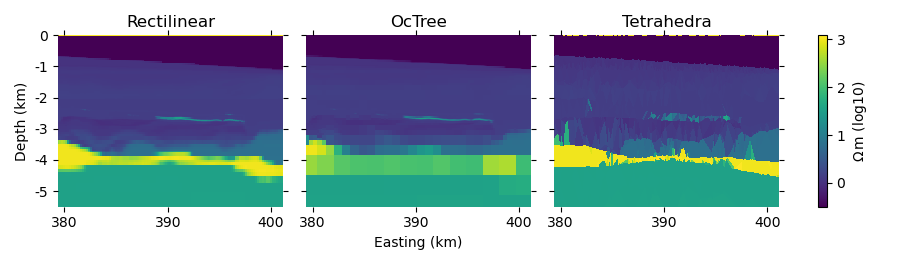

emg3d  :: y=7517799.0
SimPEG :: y=7517849.0
Vertical exaggeration: 3.0


In [7]:
vmin, vmax = 0.32, 1200

# Initiate figure (axes shared)
fig, axs = plt.subplots(1, 3, figsize=(9, 2.65), sharey=True, sharex=True)
(ax1, ax2, ax3) = axs


# # # (A) TensorMesh # # #
e_ind = 45
print(f"emg3d  :: y={mesh_emg3d.vectorCCy[e_ind]}")
dat = mesh_emg3d.plotSlice(
    np.log10(model_emg3d.property_x.ravel('F')),
    ind=e_ind, normal="Y", ax=ax1,
    clim=[np.log10(vmin), np.log10(vmax)],
    #pcolor_opts={"norm": LogNorm(vmin=vmin, vmax=vmax)}
)
ax1.set_title('Rectilinear')
ax1.set_ylabel('Depth (km)')
ax1.set_xlabel('')
ax1.set_rasterized(True)


# # # (B) OcTreeMesh (ax4-ax6) # # #

s_ind = 508 # Inline
print(f"SimPEG :: y={mesh_simpeg.vectorCCy[s_ind]}")
# Plot Ex-field
mesh_simpeg.plotSlice(
    rhoh, normal="Y", ind=s_ind, ax=ax2,
    pcolor_opts={"norm": LogNorm(vmin=vmin, vmax=vmax)}
)
ax2.set_title('OcTree')
ax2.set_xlabel('Easting (km)')
ax2.set_ylabel('')
ax2.set_rasterized(True)


# # # (C) TetrahedralMesh (ax7-ax9) # # #

ax3.set_title('Tetrahedra')
ax3.tripcolor(xtri, ytri, tri, u, rasterized=True, norm=LogNorm(vmin=vmin, vmax=vmax))

# # # FINALIZE # # #

# Plot survey over meshes.
#for ax in axs:
#    ax.plot(data.attrs['rec_x'], data.attrs['rec_z'], 'C1*', ms=5)
#    ax.plot(data.src_x[::2], data.data_il.attrs['src_z'], 'C0.')

# Set x- and y-limits
ax1.set_xlim([data.src_x[0], data.src_x[-1]])
ax1.set_ylim([-5500, 0])

# Turn spines off, but ticks on all sides.
for ax in axs.ravel():
    [ax.spines[k].set_visible(False) for k in ax.spines.keys()]
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

# Reduce number of ticks.
ax1.set_xticks(1000*np.array([380, 390, 400]))
ax1.set_xticklabels(['380', '390', '400'])
ax1.set_yticks(-1000*np.arange(6)[::-1])
ax1.set_yticklabels(['-5', '-4', '-3', '-2', '-1', '0'])

# Make tight, leave space for colorbar.
fig.tight_layout(rect=[0, 0, 0.95, 1])

# Colorbar.
c = fig.colorbar(dat[0], ax=axs, fraction=0.025)
c.ax.set_ylabel("$\Omega\,$m (log10)")

# Print exaggeration.
fw, fh = ax1.get_figure().get_size_inches()
_, _, aw, ah = ax1.get_position().bounds
ratio = (fh * ah) / (fw * aw)
ratio /= np.diff(ax1.get_ylim()) / np.diff(ax1.get_xlim())
print(f"Vertical exaggeration: {ratio[0]:.1f}")

# Save and show.
fig.savefig(f'../manuscript/figures/results-marlim_allmodels.pdf', bbox_inches='tight')
fig.show()

In [8]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Thu Oct 22 12:17:16 2020 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49)
  [GCC 7.5.0]

             numpy : 1.19.1
             scipy : 1.5.2
             numba : 0.51.2
             emg3d : 0.12.0
           empymod : 2.0.2
            xarray : 0.16.0
        discretize : 0.5.1
              h5py : 2.10.0
        matplotlib : 3.3.1
           IPython : 7.18.1

  Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------